In [147]:
import pandas as pd
from matplotlib import pyplot as pl
import numpy as np
import seaborn as sns
sns.set_style("white")

def reverse_transcribe(seq):
    watson_crick = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    ls = len(seq)
    snew = ''
    for i in range(ls):
        if not seq[ls-i-1] in watson_crick.keys():
            snew += seq[ls-i-1]
        else:
            snew += watson_crick[seq[ls-i-1]]
    return snew

## Reading in barcode extraction output and comparing it to what we had before

In [148]:
new = pd.read_csv('bcs_extracted_compiled.csv')
comp = pd.read_csv('Old/Reconciled_BCs_PTH-JUN-18.csv')

In [156]:
def change_filename(f):
    if '_R1_0' in f:
        return f[:f.index('_R1_0')].replace('.', '_')
    elif '.R1' in f:
        return f[:f.index('.R1')].replace('.', '_')

comp['File'] = comp['FULL_WGS_SAMPLE_ID'].apply(lambda f: change_filename(f))
len(new), len(comp), len(set(new['File'])), len(set(comp['File'])), len(set(new['File']).intersection(set(comp['File'])))

(1328, 1362, 1328, 1315, 1311)

In [160]:
td = new.merge(comp, on='File', how='inner')
fd = pd.read_csv('raw_file_reads.csv')
file_reads = {str(di)+'_'+change_filename(f): r for di, f, r in fd.as_matrix(['directory', 'file', 'reads'])}
td['reads'] = td['File'].apply(lambda f: file_reads.setdefault(f, np.nan))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [161]:
def get_top_count(c):
    if pd.notnull(c):
        return int(str(c).split(';')[0])
    else:
        return 0

td['dbc_top_count'] = td['dbc_counts'].apply(lambda c: get_top_count(c))
td['dbc_top'] = td['dbcs'].apply(lambda b: str(b).split(';')[0])
td['ebc_top_count'] = td['ebc_counts'].apply(lambda c: get_top_count(c))
td['ebc_top_rc'] = td['ebcs'].apply(lambda b: reverse_transcribe(str(b).split(';')[0]))

## Sanity check: showing that bc counts (usually / roughly) correlate with the number of reads for a sample

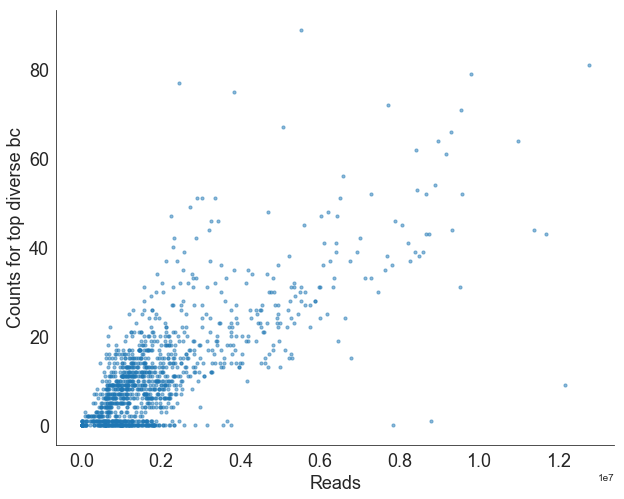

In [162]:
f, sub = pl.subplots(1, 1, figsize=(10, 8))
sub.scatter(td['reads'], td['dbc_top_count'], s=10, alpha=0.5)
sub.set_xlabel('Reads', fontsize=18)
sub.set_ylabel('Counts for top diverse bc', fontsize=18)
sub.tick_params(axis='both', which='major', labelsize=18)
sns.despine()

## OK comparing to what Parris had by way of Lucas' script:

In [163]:
td.new_dbc_match = td.apply(lambda r: r.dbc_top == r['LH_Diverse.BC'], axis=1)
td.new_ebc_match = td.apply(lambda r: r.ebc_top_rc == r['LH_Environment.BC'], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [164]:
def standardize_lh_bc(b):
    if pd.notnull(b) and str(b) != 'ABSENT' and str(b) != 'None':
        return b
    else:
        return 'ABSENT'

td['LH_dbc_new'] = td['LH_Diverse.BC'].apply(lambda b: standardize_lh_bc(b))
td['LH_ebc_new'] = td['LH_Environment.BC'].apply(lambda b: standardize_lh_bc(b))

In [165]:
print('Out of', len(td), 'samples')
print(len(td[td.dbc_top_count==0]), 'samples have no diverse bc found')
print(len(td[td.dbc_top_count>2]), 'samples have a diverse bc with at least 3 counts')
print(len(td[td['LH_dbc_new'] != 'ABSENT']), 'samples have a diverse BC hit in Lucas output')
print(len(td[td.new_dbc_match]), 'of the dbc calls agree')
print(len(td[td['LH_dbc_new'] != 'ABSENT'].loc[td.dbc_top_count==0]), 'where Lucas has a diverse bc and I do not')
print(len(td[td['LH_dbc_new'] == 'ABSENT'].loc[td.dbc_top_count>2]), 'where I have a diverse bc and Lucas does not')
dbc_disagree_files = list(td[td['LH_dbc_new'] != 'ABSENT'].loc[td.dbc_top_count>0].loc[~td.new_dbc_match]['File'])
print(len(dbc_disagree_files), 'where the two disagree\n')
print(len(td[td.ebc_top_count==0]), 'samples have no environment bc found')
print(len(td[td.ebc_top_count>2]), 'samples have a environment bc with at least 3 counts')
print(len(td[td['LH_ebc_new'] != 'ABSENT']), 'samples have a environment BC hit in Lucas output')
print(len(td[td.new_ebc_match]), 'of the ebc calls agree')
print(len(td[td['LH_ebc_new'] != 'ABSENT'].loc[td.ebc_top_count==0]), 'where Lucas has a environment bc and I do not')
print(len(td[td['LH_ebc_new'] == 'ABSENT'].loc[td.ebc_top_count>2]), 'where I have a environment bc and Lucas does not')
ebc_disagree_files = list(td[td['LH_ebc_new'] != 'ABSENT'].loc[td.ebc_top_count>0].loc[~td.new_ebc_match]['File'])
print(len(ebc_disagree_files), 'where the two disagree')

Out of 1311 samples
253 samples have no diverse bc found
918 samples have a diverse bc with at least 3 counts
712 samples have a diverse BC hit in Lucas output
578 of the dbc calls agree
19 where Lucas has a diverse bc and I do not
260 where I have a diverse bc and Lucas does not
115 where the two disagree

120 samples have no environment bc found
1133 samples have a environment bc with at least 3 counts
856 samples have a environment BC hit in Lucas output
714 of the ebc calls agree
5 where Lucas has a environment bc and I do not
300 where I have a environment bc and Lucas does not
137 where the two disagree


## Looking at the disagreements:

In [166]:
print(len(set(ebc_disagree_files).intersection(set(dbc_disagree_files))), 'where both dbc and ebc disagree')

32 where both dbc and ebc disagree


In [167]:
td[td.File.isin(ebc_disagree_files + dbc_disagree_files)][['File', 'ebc_top_rc', 'ebc_counts', 'LH_ebc_new', 'dbc_top', 'dbc_counts', 'LH_dbc_new']].to_csv('disagreement.csv', index=False)